# POC using object recognition in Encoder-Part (CNN)
Approach:
* Transfer captions to entities
* Check quality of recognition
* Use net as Decoder-Part

# Imports

In [73]:
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns

import urllib.request
from urllib.parse import urlparse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

#https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.xception import Xception
from keras.models import Model
from keras import metrics
from keras.callbacks import ModelCheckpoint, TensorBoard
from numba import cuda

import sklearn.model_selection as skms
from sklearn.utils import class_weight
import sklearn.feature_extraction.text as skfet

import spacy
import nltk
import nltk.stem as nstem
import sklego.meta as sklmet

#from wcs.google import google_drive_share
import urllib.request
from urllib.parse import urlparse

#from google.colab import drive
import datetime as dt
import time

import warnings
warnings.simplefilter(action='ignore')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Configuration

In [14]:
# Runtime config
RUN_ON_KAGGLE = False

# Model
MODEL_NAME = "InceptionV3_customized"
DO_TRAIN_VALID_SPLIT = False

BATCH_SIZE = 64*4
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

DO_SHUFFLE = False
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

IMG_DIMS = [299, 299]
IMG_CHANNELS = 3  # Keep RGB color channels to match the input format of the model

# Data pipeline
DP_TFDATA = "Data pipeline using tf.data"
DP_IMGGEN = "Data pipeline using tf.keras.ImageGenerator"
DP = DP_TFDATA


# Directories and filenames
if RUN_ON_KAGGLE:
    FP_CAPTIONS = '../input/flickr8k/captions.txt'
    DIR_IMAGES = '../input/flickr8k/Images/'
    DIR_IMAGE_FEATURES = '../input/aida-image-captioning/Images/'
    DIR_MODEL_STORE = './models/'
    DIR_MODEL_LOG = './models/'
    DIR_RESULT_STORE = './results/'
    DIR_TENSORBOARD_LOG = './tensorboard/'
    DIR_INTERIM = "./models/data/interim/"
    DIR_RAW = "./models/data/raw/"
else:
    FP_CAPTIONS = '../data/raw/flickr8k/captions.txt'
    DIR_IMAGES = '../data/raw/flickr8k/Images/'
    DIR_IMAGE_FEATURES = '../data/interim/aida-image-captioning/Images/'
    DIR_MODEL_STORE = f'../models/{MODEL_NAME}/'
    DIR_MODEL_LOG = f'../models/logs/{MODEL_NAME}/'
    DIR_RESULT_STORE = f'../data/results/{MODEL_NAME}/'
    DIR_TENSORBOARD_LOG = './tensorboard_logs/scalars/'
    DIR_INTERIM = '../data/interim/'
    DIR_RAW = "../data/raw/"

SEED = 42

# Set the max column width to see the complete caption
pd.set_option('display.max_colwidth',-1) 

# Helper functions

In [68]:
def get_lemma_text(text: str) -> str:
    """Get roots of words"""
    # Split text to list
    l_text = text.lower().split()

    # Lemmatize
    lemma = nstem.WordNetLemmatizer()
    for i, t in enumerate(l_text):
        tl = lemma.lemmatize(t)
        if tl != t:
            l_text[i] = tl

    return " ".join(l_text)

In [6]:
# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
#tf.test.gpu_device_name()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Create virtual GPUs
    try:
        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],
        )

        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK 
            gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],            
        )
    except:
        # Virtual devices must be set before GPUs have been initialized
        print("Warning: During GPU handling.")
        pass
    finally:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs\n")

# Set runtime context and batch size
l_rtc_names = [
    "multi-GPU_MirroredStrategy",
    "multi-GPU_CentralStorageStrategy",
    "1-GPU",
    "CPUs",
    "multi-GPU_MirroredStrategy_NCCL-All-Reduced",
]
l_rtc = [
    tf.distribute.MirroredStrategy().scope(),
    tf.distribute.experimental.CentralStorageStrategy().scope(),
    tf.device("/GPU:0"),
    tf.device("/CPU:0"),
    tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce()).scope(),
]
if len(gpus) == 0:
    rtc_idx = 3
    batch_size = 64

elif len(gpus) == 1:
    rtc_idx = 2
    batch_size = 4*256

elif len(gpus) > 1:
    rtc_idx = 0
    batch_size = 8*256

runtime_context = l_rtc[rtc_idx]

print(f"\nRuntime Context: {l_rtc_names[rtc_idx]}")
print(f"Recommended Batch Size: {batch_size} datasets")

1 Physical GPU, 2 Logical GPUs

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1'], variable_device = '/device:CPU:0'
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Runtime Context: 1-GPU
Recommended Batch Size: 1024 datasets


# Datapipeline based on tf.data

In [7]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(DIR_IMAGES + filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_DIMS[0], IMG_DIMS[1]])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label


def create_dataset(filenames, labels, cache=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if cache == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        if DO_SHUFFLE:
            dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

# Preproc

In [17]:
# Create a dataframe which summarizes the image, path & captions as a dataframe
# Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.
df = pd.read_csv(FP_CAPTIONS)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [18]:
# Aggregateion by filename
df_agg = captions_df.groupby("image").first().reset_index()
df_agg.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [56]:
# Get caption labels
sp = spacy.load('en_core_web_sm') # english language model
sp_cap = sp(df_agg.caption[1])
print(sp_cap)
for idx, token in enumerate(sp_cap):
    if idx == 0:
        print(f"{'Word pos.':^10} {'Text':<15} {'POS-Tag':^10} {'POS-Tag expl.'}")
    print(f"{idx+1:^10} {token.text:<15} {token.tag_:^10} {token.pos_:<5} - {spacy.explain(token.tag_)}")

cap_cleaned = " ".join(set([token.text for token in sp_cap if token.tag_ in ["ADJ", "AUX", "JJ", "NN", "NNS", "VB", "VBG", "VBN", "VBZ"]]))
cap_cleaned

In [66]:
df["caption_short"] = df.caption.map(lambda x: " ".join(set([token.text for token in sp(x) if token.tag_ in ["ADJ", "AUX", "JJ", "NN", "NNS", "VB", "VBG", "VBN", "VBZ"]])))
df.head()

In [70]:
df["caption_lemm"] = df.apply(lambda r: get_lemma_text(r["caption_short"]), axis=1)
df.head()

,image,caption,caption_short,caption_lemm
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,set climbing dress child entry pink stairs is way,set climbing dress child entry pink stair is way
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,wooden building going girl,wooden building going girl
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,little climbing wooden playhouse girl,little climbing wooden playhouse girl
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,little climbing playhouse stairs girl,little climbing playhouse stair girl
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,little wooden dress pink girl cabin going,little wooden dress pink girl cabin going


In [76]:
# Train / test split
df_train, df_test = skms.train_test_split(df, test_size=.2, random_state=42)
print(df_train.shape, df_test.shape)

# Def feature and target column
feat_col = "caption_lemm"

# Build up feature and target structure
X_train = df_train[feat_col]
X_test = df_test[feat_col]

In [78]:
# Vectorize captions
vectorizer = skfet.TfidfVectorizer()

# Train it
X_train_CountVec = vectorizer.fit_transform(X_train)
print(f"{'Train feature matrix shape:':<30} {X_train_CountVec.shape}")

# Transform test features to tokens
X_test_CountVec = vectorizer.transform(X_test)
print(f"{'Test feature matrix shape:':<30} {X_test_CountVec.shape}")

Train feature matrix shape:    (32364, 5925)
Test feature matrix shape:     (8091, 5925)


 # Create ImageGenerators

In [11]:
print(DP)

if DO_TRAIN_VALID_SPLIT:
    df_train, df_valid = skms.train_test_split(df, test_size=0.2, random_state=SEED)
else:
    df_train = df
    df_valid = df_test

df_train.shape, df_valid.shape

Data pipeline using tf.data


((273876, 33), (1000, 27))

In [12]:
#tf.autograph.set_verbosity(3, True)

if DP == DP_IMGGEN:
    datagen = ImageDataGenerator(rescale=1 / 255.)#, validation_split=0.1)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="genre_ids2_list",
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True,
        class_mode="categorical",
        target_size=(299, 299),
        subset='training',
        validate_filenames=True
    )

    valid_generator = datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="genre_ids2_list",
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False,
        class_mode="categorical",
        target_size=(299, 299),
        subset='training',
        validate_filenames=True
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="genre_ids2_list",
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False,
        class_mode="categorical",
        target_size=(299, 299),
        subset='training',
        validate_filenames=True
    )
else:
    X_train = df_train.filename.to_numpy()
    y_train = df_train[LABEL_COLS].to_numpy()
    X_valid = df_valid.filename.to_numpy()
    y_valid = df_valid[LABEL_COLS].to_numpy()
    X_test = df_test.filename.to_numpy()
    y_test = df_test[LABEL_COLS].to_numpy()

    train_generator = create_dataset(X_train, y_train, cache=True)
    valid_generator = create_dataset(X_valid, y_valid, cache=True)
    test_generator = create_dataset(X_test, y_test, cache=True)

    print(f"{len(X_train)} training datasets, using {y_train.shape[1]} classes")
    print(f"{len(X_valid)} validation datasets, unsing {y_valid.shape[1]} classes")
    print(f"{len(X_test)} training datasets, using {y_test.shape[1]} classes")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
273876 training datasets, using 19 classes
1000 validation datasets, unsing 19 classes
1000 training datasets, using 19 classes


<AxesSubplot:title={'center':'Label distributions'}>

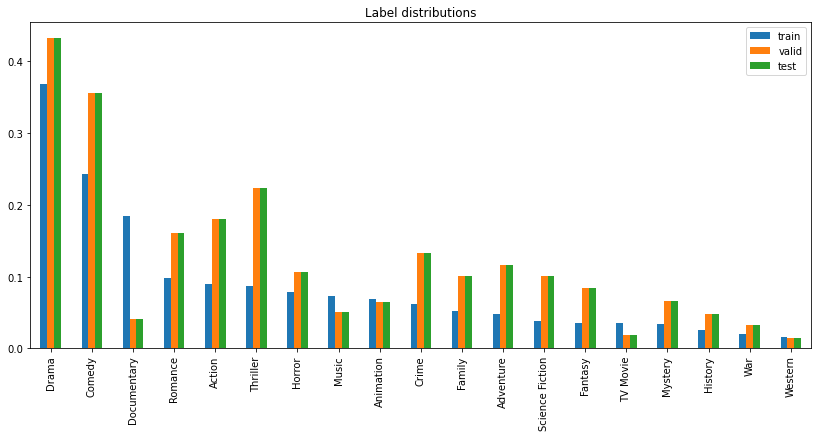

In [13]:
# Show label distribution
df_tmp = df = pd.DataFrame(
    {
        'train': df_train[LABEL_COLS].sum()/len(df_train), 
        'valid': df_valid[LABEL_COLS].sum()/len(df_valid), 
        'test': df_test[LABEL_COLS].sum()/len(df_test)
    }, 
    index=LABEL_COLS
)
df_tmp.sort_values('train', ascending=False).plot.bar(figsize=(14,6), title='Label distributions')

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273876 entries, 0 to 274854
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               273876 non-null  int64         
 1   original_title   273876 non-null  object        
 2   release_date     273876 non-null  datetime64[ns]
 3   popularity       273876 non-null  float64       
 4   adult            273876 non-null  bool          
 5   video            273876 non-null  bool          
 6   poster_url       273876 non-null  object        
 7   poster_exists    273876 non-null  bool          
 8   filename         273876 non-null  object        
 9   genre_id         273876 non-null  object        
 10  genre_ids2       273876 non-null  object        
 11  genre_ids2_list  273876 non-null  object        
 12  genre_id_count   273876 non-null  int64         
 13  Action           273876 non-null  int64         
 14  Adventure        273

In [15]:
from sklearn.utils import class_weight

#In order to calculate the class weight do the following
class_weights = class_weight.compute_class_weight('balanced',
                                                  LABEL_COLS, # np.array(list(train_generator.class_indices.keys()),dtype="int"), 
                                                  np.array(df_train.genre_names.explode()))

class_weights = dict(zip(list(range(len(class_weights))), class_weights))
number_of_classes = len(LABEL_COLS)
pd.DataFrame({'weight': [i[1] for i in class_weights.items()]}, index=[LABEL_COLS[i[0]] for i in class_weights.items()])

,weight
Action,0.978046
Adventure,1.821594
Animation,1.265968
Comedy,0.359334
Crime,1.400726
Documentary,0.472618
Drama,0.237221
Family,1.654197
Fantasy,2.417686
History,3.348684


# Create Model

In [10]:
def model_create(model_name: str):
    """Create the customized InceptionV3 model"""
    base_inc_res = tf.keras.applications.InceptionV3(
        include_top=False, 
        weights='imagenet',
        input_shape=(299,299,3)
    )
    base_inc_res.trainable = False

    inputs = keras.Input(shape=(299,299,3))
    x = base_inc_res(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(19, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=x, name=model_name)
    return model, model_name

In [11]:
model = model_create(MODEL_NAME)
model.summary()

87916544/87910968 [==============================] - 6s 0us/step
Model: "InceptionV3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 8, 8, 2048)        8192      
_________________________________________________________________
dense (Dense)                (None, 8, 8, 1024)        2098176   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 8, 512)         524800    
________________________________________________________

# Run model

In [ ]:
#tf.debugging.set_log_device_placement(True)
l_rtc_names = [
    "2-GPU_MirroredStrategy",
    "2-GPU_CentralStorageStrategy",
    "1-GPU",
    "56_CPU",
    "2-GPU_MirroredStrategy_NCCL-All-Reduced",
]
l_rtc = [
    tf.distribute.MirroredStrategy().scope(),
    tf.distribute.experimental.CentralStorageStrategy().scope(),
    tf.device("/GPU:0"),
    tf.device("/CPU:0"),
    tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce()).scope(),
]

# Load Model
i = 0
runtime_context = l_rtc[i]
######for i, runtime_context in enumerate(l_rtc):
print(f"Runtime Context: {l_rtc_names[i]}")

# Create and train model
with runtime_context:
    model_name = MODEL_NAME
    model = create_model(model_name)

    # Start time measurement
    tic = time.perf_counter()

    # Define Tensorflow callback log-entry
    model_name_full = f"{model.name}_{l_rtc_names[i]}_{dt.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tb_logdir = f"{TENSORBOARD_LOGDIR}{model_name_full}"
    # mark loaded layers as not trainable
    # except last layer
    leng = len(model.layers)
    print(leng)
    for i,layer in enumerate(model.layers):
        if leng-i == 5:
          print("stopping at",i)
          break
        layer.trainable = False

    # Def metrics
    threshold = 0.5
    f1_micro = tfa.metrics.F1Score(num_classes=19, average='micro', name='f1_micro',threshold=threshold), 
    f1_macro = tfa.metrics.F1Score(num_classes=19, average='macro', name='f1_macro',threshold=threshold)
    f1_weighted = tfa.metrics.F1Score(num_classes=19,  average='weighted', name='f1_score_weighted',threshold=threshold)

    # Compile model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy", 
        metrics=[
            "accuracy",
            "categorical_accuracy",
            tf.keras.metrics.AUC(multi_label = True),#,label_weights=class_weights),
            f1_micro,
            f1_macro,
            f1_weighted]
    )

    print("create callbacks")
    #filepath = "model_checkpoints/{model_name}_saved-model-{epoch:02d}-{val_f1_score_weighted:.2f}.hdf5"
    #cb_checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score_weighted', verbose=1, save_best_only=True, mode='max')

    cb_tensorboard = TensorBoard(
        log_dir = tb_logdir,
        histogram_freq=0, 
        update_freq='epoch',
        write_graph=True, 
        write_images=False)
    #callbacks_list = [cb_checkpoint, cb_tensorboard]
    #callbacks_list = [cb_checkpoint]
    callbacks_list = [cb_tensorboard]

    # Model summary
    print(model.summary())

    # Train model
    print("model fit")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        # reduce steps per epochs for faster epochs
        #steps_per_epoch = math.ceil(266957 / BATCH_SIZE /8),
        class_weight = class_weights,
        callbacks=callbacks_list,
        use_multiprocessing=False
    )

    # Measure time of loop
    toc = time.perf_counter()
    secs_all = toc - tic
    mins = int(secs_all / 60)
    secs = int((secs_all - mins*60))
    print(f"Time spend for current run: {secs_all:0.4f} seconds => {mins}m {secs}s")

    # Predict testset
    y_pred_test = model.predict(test_generator)

    # Store resulting model
    try:
        fpath = MODEL_DIR + model_name_full
        print(f"Saving final model to file {fpath}")
        model.save(fpath)
    except Exception as e:
        print("-------------------------------------------")
        print(f"Error during saving of final model\n{e}")
        print("-------------------------------------------\n")

    try:
        fpath = MODEL_DIR + model_name_full + ".ckpt"
        print(f"Saving final model weights to file {fpath}]")
        model.save_weights(fpath)
    except Exception as e:
        print("-------------------------------------------")
        print(f"Error during saving of final model weights\n{e}")
        print("-------------------------------------------\n")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3'], variable_device = '/device:CPU:0'
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Runtime Context: 2-GPU_MirroredStrategy
Loading model from file InceptionResNetV2_corrected_20210323T223046Z.hd5...
INFO:tensorflow:Reduce to /job:localhost/rep

# Threshold optimization

In [ ]:
from keras import metrics
threshold = 0.35
f1_micro = tfa.metrics.F1Score(num_classes=19, average='micro', name='f1_micro',threshold=threshold), 
f1_macro = tfa.metrics.F1Score(num_classes=19, average='macro', name='f1_macro',threshold=threshold)
f1_weighted = tfa.metrics.F1Score(num_classes=19,  average='weighted', name='f1_score_weighted',threshold=threshold)

In [ ]:
y_true_test = [ [1 if i in e else 0 for i in range(19)] for e in test_generator.labels]
y_true_test = np.array(y_true_test)

In [ ]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 10)

pd.DataFrame({
    'threshold': ths, 
    'f1-micro': [f1_score(y_true_test, (y_pred_test > th)*1., average="micro") for th in ths],
    'f1-weighted': [f1_score(y_true_test, (y_pred_test > th)*1., average="weighted") for th in ths],
    'class' : "all"
    }
)

In [ ]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 9)

df_ths = pd.DataFrame({'threshold' : ths}
)

for cl in range(19):
    col = pd.DataFrame({f'f1-class_{cl}': [f1_score(y_true_test[:,cl], (y_pred_test[:,cl] > th)*1.) for th in ths] 
                       })
    df_ths=pd.concat([df_ths,col],axis="columns")

df_ths.style.highlight_max(color = 'lightgreen', axis = 0)
df_ths

In [ ]:
argmax_index=df_ths.iloc[:,1:].idxmax(axis=0)
class_thresholds = df_ths.threshold[argmax_index].values
class_thresholds

In [ ]:
f1_micro_opt_th = f1_score(y_true_test, (y_pred_test > class_thresholds)*1., average="micro")
f1_weighted_opt_th = f1_score(y_true_test, (y_pred_test > class_thresholds)*1., average="weighted")
print("Class thresholds optimized on test set:",
        f"f1_micro_opt_th: {f1_micro_opt_th:.3f}, f1_weighted_opt_th: {f1_weighted_opt_th:.3f}",
      sep="\n")

In [ ]:
#datagen = ImageDataGenerator(rescale=1 / 255.)#, validation_split=0.1)
BATCH_SIZE = 64
train2_generator = datagen.flow_from_dataframe(
    dataframe=df.loc[~df.is_holdout].sample(20000),
    directory=IMAGES_DIR,
    x_col="filename",
    y_col="genre_id",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode="categorical",    
    target_size=(299, 299),
    subset='training',
    validate_filenames=False
)

In [ ]:
y_pred_train = model.predict(train2_generator)

In [ ]:
y_true_train = [ [1 if i in e else 0 for i in range(19)] for e in train2_generator.labels]
y_true_train = np.array(y_true_train)

In [ ]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 9)

df_ths = pd.DataFrame({'threshold' : ths}
)

for cl in range(19):
    col = pd.DataFrame({f'f1-class_{cl}': [f1_score(y_true_train[:,cl], (y_pred_train[:,cl] > th)*1.) for th in ths]          
                       })
    df_ths=pd.concat([df_ths,col],axis="columns")

df_ths.style.highlight_max(color = 'lightgreen', axis = 0)
df_ths

In [ ]:
argmax_index=df_ths.iloc[:,1:].idxmax(axis=0)
class_thresholds = df_ths.threshold[argmax_index].values
class_thresholds

In [ ]:
f1_micro_opt_th = f1_score(y_true, (y_pred > class_thresholds)*1., average="micro")
f1_weighted_opt_th = f1_score(y_true, (y_pred > class_thresholds)*1., average="weighted")
print("Class thresholds optimized on training set:",
        f"f1_micro_opt_th: {f1_micro_opt_th:.3f}, f1_weighted_opt_th: {f1_weighted_opt_th:.3f}",
      sep="\n")

In [1]:
df_train

NameError: name 'df_train' is not defined

In [15]:
df[df.original_title.str.contains("brian")==True]

,id,original_title,release_date,popularity,adult,video,poster_url,poster_exists,filename,genre_id,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
30228,752866,Kama Wosi: Music in the Trobriand Islands,1971-03-10,0.6,False,False,https://www.themoviedb.org/t/p/w500//bdmkZk1flJD7IFP5We4eyZiKhGm.jpg,True,bdmkZk1flJD7IFP5We4eyZiKhGm.jpg,[99],...,0,0,0,0,0,0,0,0,0,0
170485,479935,The Cumbrian Coast,1997-12-01,0.6,False,False,https://www.themoviedb.org/t/p/w500//9Fzus94L0lSwNWUKdfKPw8K0y3y.jpg,True,9Fzus94L0lSwNWUKdfKPw8K0y3y.jpg,[99],...,0,0,0,0,0,0,0,0,0,0
